# Gibbs sampling
##The simplified example of Gibbs Sampling implementation for proteins/protein regions of the same size with defined parameters of k-mer length, number of Randomized Motif Search iterations, and number of GibbsSampler iterations

# Install the packages

In [1]:
!pip install logomaker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 43.6 MB/s eta 0:00:00


# Generate/Upload the sequences

In [2]:
from random import randint, choices
import os
# Generate random protein sequences
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
if not os.path.exists("protein_sequences.txt"):
    with open("protein_sequences.txt", "w") as f:
        for _ in range(20):
            protein_length = 50
            protein = "".join(choices(amino_acids, k=protein_length))
            f.write(protein + "\n")

# Upload the sequences
with open('protein_sequences.txt') as input_data:
    seqs = [line.strip() for line in input_data.readlines()]

# Select the parameters

In [3]:
k = 15 # define k-mer length
Nr = 20 # define number of Randomized Motif Search iterations
Ng = 2000 # define number of GibbsSampler iterations

# Run the Gibbs Sampling

In [4]:
def HammingDistance(seq1,seq2):
  if len(seq1) != len(seq2):
    raise ValueError('Sequences are not equal length')
  return sum(char1 != char2 for char1, char2 in zip(seq1, seq2))

def Score(motifs):
	score = 0
	for i in range(len(motifs[0])):
		column = ''.join([motifs[j][i] for j in range(len(motifs))])
		score += min([HammingDistance(column, char*len(column)) for char in alphabet])
	return score

def Profile(motifs):
	profile = []
	for i in range(len(motifs[0])):
		column = ''.join([motifs[j][i] for j in range(len(motifs))])
		profile.append([float(column.count(char)+1)/float(len(column)+len(alphabet)) for char in alphabet])
	return profile

def Kmer(seq,k,profile):
	char_positions = {char:index for index,char in enumerate(alphabet)}
	best_char_probabilities = [-1, None]
	for i in range(len(seq)-k+1):
		current_probability = 1
		for j, char in enumerate(seq[i:i+k]):
			current_probability *= profile[j][char_positions[char]]
		if current_probability > best_char_probabilities[0]:
			best_char_probabilities = [current_probability, seq[i:i+k]]
	return best_char_probabilities[1]

def GibbsSampler(seqs,seqs_len,k,Ng,alphabet):
	random_start_positions = [randint(0,len(seqs[0])-k) for a in range(seqs_len)]
	motifs = [seqs[i][r:r+k] for i,r in enumerate(random_start_positions)]

	best_score = [Score(motifs), motifs]

	for i in range(Ng):
		random_index = randint(0,seqs_len-1)
		current_profile = Profile([motif for index, motif in enumerate(motifs) if index!=random_index])
		motifs = [Kmer(seqs[index],k,current_profile) if index == random_index else motif for index,motif in enumerate(motifs)]
		current_score = Score(motifs)
		if current_score < best_score[0]:
			best_score = [current_score, motifs]

	return best_score

alphabet = "ACDEFGHIKLMNPQRSTVWY"

best_motifs = [k * len(seqs), None]

for repeat in range(Nr):
    current_motifs = GibbsSampler(seqs, len(seqs), k, Ng, alphabet)
    if current_motifs[0] < best_motifs[0]:
        best_motifs = current_motifs

# Vizualize and save the result

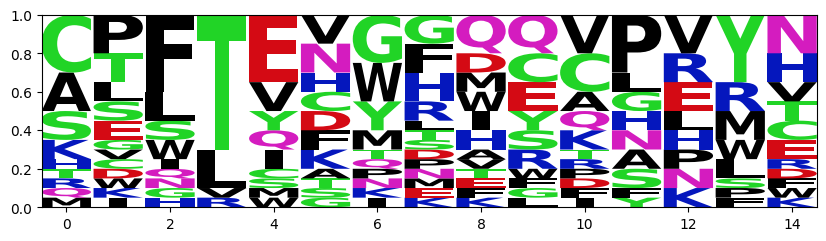

In [5]:
import logomaker as lm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def create_sequence_logo(motifs, alphabet, output_filename="sequence_logo.png"):
    if not motifs:
        print("Error: No motifs provided.")
        return

    motifs_length = len(motifs[0])
    motifs_number = len(motifs)

    alphabet_list = [symbol for symbol in alphabet]

    frequency_matrix = np.zeros((motifs_length, len(alphabet_list)))
    alphabet_dict = {symbol: index for index, symbol in enumerate(alphabet_list)}

    for i in range(motifs_length):
        for motif in motifs:
            symbol = motif[i]
            if symbol in alphabet_dict:
                frequency_matrix[i, alphabet_dict[symbol]] += 1

    frequency_matrix /= motifs_number

    df = pd.DataFrame(frequency_matrix, columns=alphabet_list)

    logo = lm.Logo(df)

    plt.savefig(output_filename)
    plt.show()
    plt.close()

create_sequence_logo(best_motifs[1],alphabet)

with open('protein_motifs.txt', 'w') as output_data:
    output_data.write('\n'.join(best_motifs[1]))